In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi Yükle
df = pd.read_csv("../data/lgs_full_data.csv")

# 1. Yıllara Göre Konu Dağılımı (Pivot Table)
topic_trends = df.pivot_table(index="Ana_Konu", columns="Yil", values="Soru_ID", aggfunc="count", fill_value=0)

# Toplam soru sayısına göre sırala (En popüler konular en üstte)
topic_trends['Total'] = topic_trends.sum(axis=1)
topic_trends = topic_trends.sort_values("Total", ascending=False).drop(columns="Total")

print("📊 Yıllara Göre Konu Dağılımı:")
display(topic_trends)

📊 Yıllara Göre Konu Dağılımı:


Yil,2018,2019,2020,2021,2022,2023,2024,2025
Ana_Konu,,,,,,,,
Paragrafta Anlam,14,5,8,10,10,11,9,10
Sözel Mantık,1,4,4,6,2,4,3,3
Dil Bilgisi,3,2,2,0,3,1,3,3
Sözcükte Anlam,0,5,2,3,1,1,1,0
Yazım Kuralları,2,3,2,0,2,1,1,2
Grafik Yorumlama,0,1,2,1,2,1,2,1
Cümle Türleri,0,0,0,0,0,0,1,0
Fiilimsiler,0,0,0,0,0,1,0,0
Söz Sanatları,0,0,0,0,0,0,0,1


In [2]:
def calculate_2026_prediction(row):
    # Ağırlıklar: Son yıllar sınavın yeni formatını daha iyi yansıtır.
    # 2025: %45, 2024: %30, 2023: %15, Diğerleri: %10 (Toplam)

    score = 0
    weights_sum = 0

    # Yıllara özel ağırlıklar
    weights = {
        2025: 4.5,
        2024: 3.0,
        2023: 1.5,
        2022: 0.5,
        2021: 0.5,
        2020: 0.0, # Pandemi yılı (Müfredat farklıydı, analize katmıyoruz)
        2019: 0.2,
        2018: 0.2
    }

    for year in row.index:
        if year in weights:
            val = row[year]
            w = weights[year]
            score += val * w
            weights_sum += w

    # Ağırlıklı Ortalama
    if weights_sum == 0: return 0
    prediction = score / weights_sum
    return prediction

# Tahminleri Hesapla
predictions = topic_trends.apply(calculate_2026_prediction, axis=1)

# Normalizasyon: Toplam soru sayısını 20'ye tamamlama
total_pred = predictions.sum()
final_counts = (predictions / total_pred * 20).round().astype(int)

# 20'ye tamamlamak için ince ayar
diff = 20 - final_counts.sum()
if diff != 0:
    # Farkı en çok soru çıkan konuya ekle/çıkar (Genelde Paragraf)
    max_topic = final_counts.idxmax()
    final_counts[max_topic] += diff

# Sonuç Tablosu
forecast_df = pd.DataFrame({
    "2024_Gercek": topic_trends[2024],
    "2025_Gercek": topic_trends[2025],
    "2026_TAHMIN": final_counts
})

print("🚀 2026 LGS Türkçe Konu Tahmini:")
display(forecast_df)

🚀 2026 LGS Türkçe Konu Tahmini:


,2024_Gercek,2025_Gercek,2026_TAHMIN
Ana_Konu,,,
Paragrafta Anlam,9,10,11
Sözel Mantık,3,3,3
Dil Bilgisi,3,3,3
Sözcükte Anlam,1,0,1
Yazım Kuralları,1,2,1
Grafik Yorumlama,2,1,1
Cümle Türleri,1,0,0
Fiilimsiler,0,0,0
Söz Sanatları,0,1,0


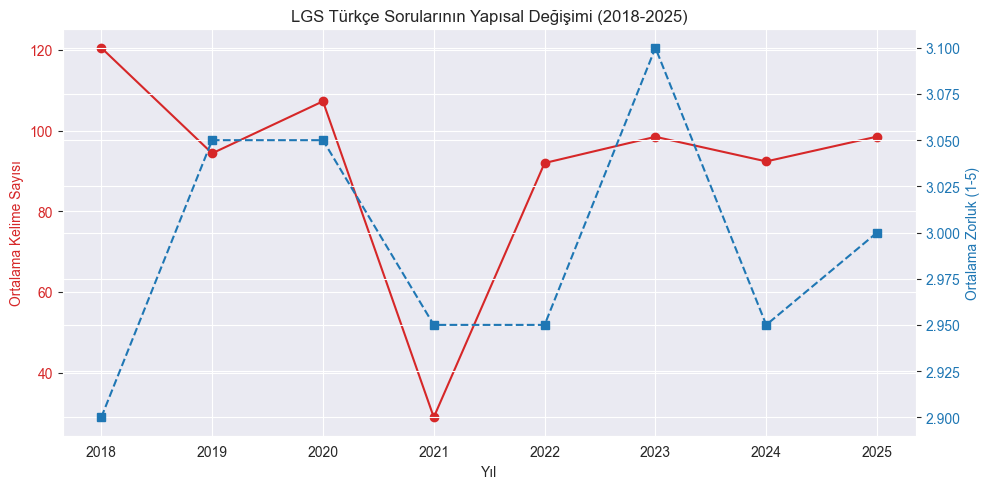


Son 3 yılın ortalama zorluğu: 3.02/5
Son 3 yılın ortalama kelime sayısı: 96 kelime
En çok artış gösteren konu: Paragrafta Anlam



In [4]:
# 1. Zorluk Trendi
difficulty_trend = df.groupby("Yil")["Zorluk"].mean()

# 2. Metin Uzunluğu Trendi (Kelimeleri sayarak)
# Soru metni + Şıkların toplam uzunluğu
df['Full_Text'] = df['Soru_Metni'].astype(str) + " " + df['Secenek_A'].astype(str) + " " + df['Secenek_B'].astype(str) + " " + df['Secenek_C'].astype(str) + " " + df['Secenek_D'].astype(str)

# Ardından kodunuza devam edebilirsiniz...
df["Kelime_Sayisi"] = df["Full_Text"].apply(lambda x: len(str(x).split()))

df["Kelime_Sayisi"] = df["Full_Text"].apply(lambda x: len(str(x).split()))
length_trend = df.groupby("Yil")["Kelime_Sayisi"].mean()

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Yıl')
ax1.set_ylabel('Ortalama Kelime Sayısı', color=color)
ax1.plot(length_trend.index, length_trend.values, color=color, marker='o', label="Soru Uzunluğu")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # İkinci eksen
color = 'tab:blue'
ax2.set_ylabel('Ortalama Zorluk (1-5)', color=color)
ax2.plot(difficulty_trend.index, difficulty_trend.values, color=color, marker='s', linestyle='--', label="Zorluk")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("LGS Türkçe Sorularının Yapısal Değişimi (2018-2025)")
fig.tight_layout()
plt.show()

# İstatistikleri metne dökelim (LLM için)
stats_summary = f"""
Son 3 yılın ortalama zorluğu: {difficulty_trend.tail(3).mean():.2f}/5
Son 3 yılın ortalama kelime sayısı: {length_trend.tail(3).mean():.0f} kelime
En çok artış gösteren konu: {forecast_df['2026_TAHMIN'].idxmax()}
"""
print(stats_summary)

In [5]:
from openai import OpenAI # veya google.genai
import os

client = OpenAI(api_key="key")

# Prompt Hazırlığı
report_prompt = f"""
Sen Türkiye'nin en iyi LGS Eğitim Koçusun. Aşağıdaki verileri kullanarak "2026 LGS Türkçe Strateji Raporu" hazırla.

--- VERİLER ---
KONU DAĞILIM TAHMİNİ (2026):
{forecast_df.to_string()}

YAPISAL ANALİZ:
{stats_summary}

--- İSTENEN RAPOR FORMATI ---
1. **Genel Bakış:** 2026 LGS Türkçe nasıl bir sınav olacak? Zorluk ve uzunluk beklentisi nedir?
2. **Banko Konular:** Hangi konulardan kesin soru bekleniyor? (Tabloyu yorumla).
3. **Sürpriz Riski:** Listede az görünen veya son yıllarda azalmış ama geri gelebilecek konular neler? (Örn: Dil Bilgisi trendi).
4. **Çalışma Programı Tavsiyesi:** Bir öğrenci haftalık çalışmasının % kaçını paragrafa, % kaçını dil bilgisine ayırmalı?

Cevabı Markdown formatında, motive edici ve profesyonel bir dille yaz.
"""

# API Çağrısı (Örnek OpenAI)
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": report_prompt}],
    temperature=0.7
)

print(response.choices[0].message.content)

# 2026 LGS Türkçe Strateji Raporu

## 1. Genel Bakış
2026 LGS Türkçe sınavı, geçmiş yılların verileri göz önüne alındığında, zorluk seviyesi açısından 3.02/5 ortalamasını koruyacak gibi görünüyor. Bu, sınavın orta zorluk seviyesinde olacağına işaret ediyor. Sınavdaki soruların ortalama kelime sayısı ise 96 civarında olacak. Bu, öğrencilerin okuma hızını ve metin anlama becerilerini geliştirmelerinin kritik olduğunu gösteriyor. 

## 2. Banko Konular
Tablodaki verilere baktığımızda, "Paragrafta Anlam" konusunun sürekli artış gösterdiğini ve 11 soruya kadar çıktığını görüyoruz. Bu, paragraf sorularının sınavın belkemiğini oluşturacağını net bir şekilde ortaya koyuyor. Sözel Mantık ve Dil Bilgisi de her yıl düzenli olarak sorulan konular arasında yer alıyor. Bu nedenle öğrencilerin bu konulara da mutlaka hazırlıklı olmaları gerekmektedir.

## 3. Sürpriz Riski
Son yıllarda az soru çıkan veya hiç çıkmayan konulara dikkat etmek faydalı olacaktır. "Yazım Kuralları" 2025'te bir artış göstermiş 